# Pulling Federal Reserve Google Trends metrics (June-September 2017)

I utilized the pytrends module, which is an Unofficial API for Google Trends. Pretty straight forward and it works pretty well.

### Import relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
import pickle

%matplotlib inline

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Instantiate pytrend dataframe and input specific search parameters

Search terms: 'federal reserve', 'yellen', 'inflation', 'unemployment'

In [2]:
pytrend = TrendReq()
pytrend.build_payload(kw_list=['federal reserve', 'yellen', 'inflation', 'unemployment rate'], geo='US', timeframe='2017-06-01 2017-09-29')

time = pytrend.interest_over_time()
time = time.loc[:, :'unemployment rate']
time = time[time.index.dayofweek < 5]

### Calculate daily score for trend metrics

In [3]:
def make_weight(y, f, i, u):
    time['weighted'] = y*time.yellen + f*time['federal reserve'] + i*time.inflation + u*time['unemployment rate']
    time['lag1'] = time.weighted.diff()
    time['lag2'] = time.lag1.diff()

In [4]:
make_weight(0.35, 0.35, 0.1, 0.2)

### Visualize metrics and scores

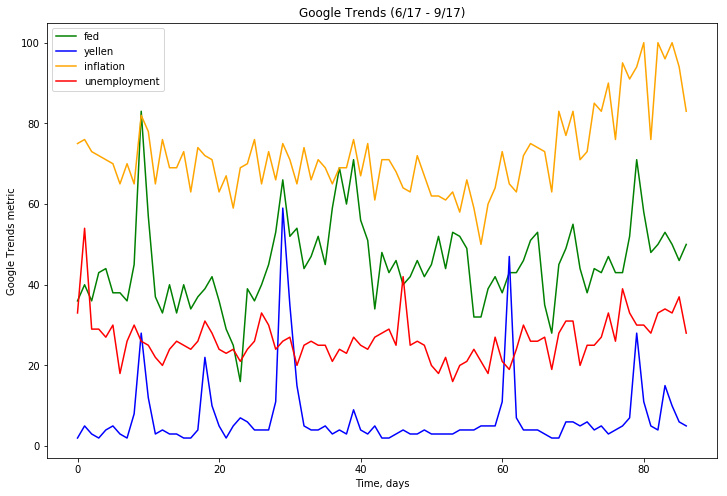

In [5]:
plt.figure(figsize=(12,8))

plt.plot(time['federal reserve'].tolist(), label='fed', color='green')
plt.plot(time.yellen.tolist(), label='yellen', color='blue')
plt.plot(time.inflation.tolist(), label='inflation', color='orange')
plt.plot(time['unemployment rate'].tolist(), label='unemployment', color='red')
plt.xlabel('Time, days')
plt.ylabel('Google Trends metric')
plt.title('Google Trends (6/17 - 9/17)')
plt.legend();

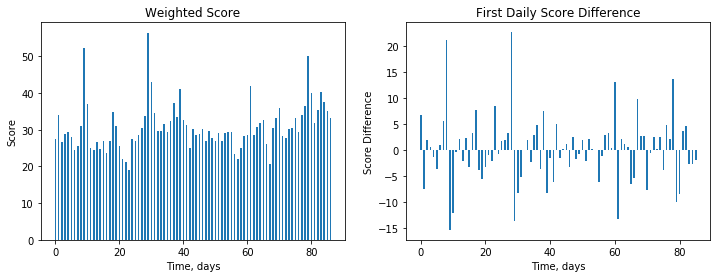

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].bar(np.arange(len(time)), time.weighted, 0.5)
ax[0].set_xlabel('Time, days')
ax[0].set_ylabel('Score')
ax[0].set_title('Weighted Score')
ax[1].bar(np.arange(len(time)-1), time.weighted.diff().iloc[1:], 0.5)
ax[1].set_xlabel('Time, days')
ax[1].set_ylabel('Score Difference')
ax[1].set_title('First Daily Score Difference');

### Time Series seasonal decomposition and ACF

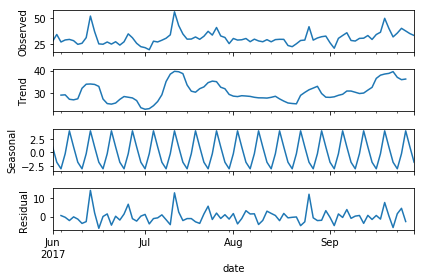

In [7]:
decomposition = seasonal_decompose(time.weighted, model='additive')
decomposition.plot();

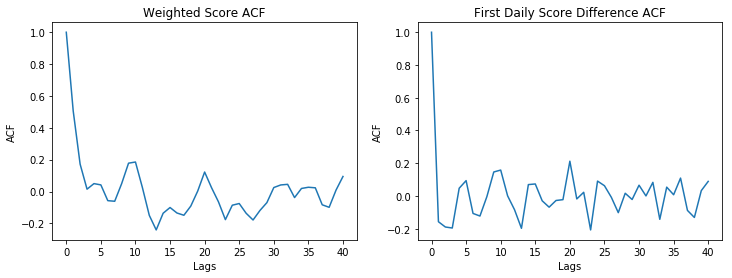

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(acf(time.weighted))
ax[0].set_xlabel('Lags')
ax[0].set_ylabel('ACF')
ax[0].set_title('Weighted Score ACF')
ax[1].plot(acf(time.lag1.iloc[1:]))
ax[1].set_xlabel('Lags')
ax[1].set_ylabel('ACF')
ax[1].set_title('First Daily Score Difference ACF');

## Save Google Trend data

In [9]:
with open('/Users/samfunk/ds/metis/project_luther/trends.pkl', 'wb') as f:
    pickle.dump(time, f)